### Light BGM for Bandgap Prediction

In [2]:
#pip install lightgbm

In [17]:
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [41]:
# df = pd.read_csv('../data/x_y_bandgap_normalized.csv')
df = pd.read_csv('../data/bandgap_dataset_processed.csv')
df2 = pd.read_csv('../data/x_y_bandgap_normalized.csv')

In [181]:
df_raw = pd.read_excel('../data/dataset_1053.xlsx')
df_raw.drop(columns=['A2BBX6', 'A', 'B1', 'B2', 'X'], inplace=True)

In [206]:
X_raw = df_raw.drop(columns=['band_gap'])
y_raw = df_raw['band_gap']

X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)   # fit + transform
X_val   = scaler.transform(X_val)         # transform only
X_test  = scaler.transform(X_test)        # transform only

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [ ]:
{'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 0.5, 'num_leaves': 31, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.6}

In [ ]:
best_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': 10,
    'n_estimators': 300,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'reg_alpha': 0.5,
    'reg_lambda': 0,
    'verbose': -1
}

# num_round = 300
bst = lgb.train(
    best_params, 
    train_data,  
    valid_sets=[val_data], 
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
    # early_stopping_rounds=50, 
    # verbose_eval=False
)
# y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
# mse = mean_squared_error(y_test, y_pred)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[151]	valid_0's rmse: 0.763631


In [222]:
def eval(y_pred, y_actual):
    mse = mean_squared_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)
    print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')

In [223]:
best_model = bst#random_search.best_estimator_
y_val_pred = best_model.predict(X_val, num_iteration=bst.best_iteration)
y_train_pred =  best_model.predict(X_train, num_iteration=bst.best_iteration)

print('TRAIN')
eval(y_train, y_train_pred)
print('VAL')
eval(y_val, y_val_pred)

TRAIN
MSE: 0.0950, MAE: 0.2199, R2: 0.9678
VAL
MSE: 0.5831, MAE: 0.5162, R2: 0.7740


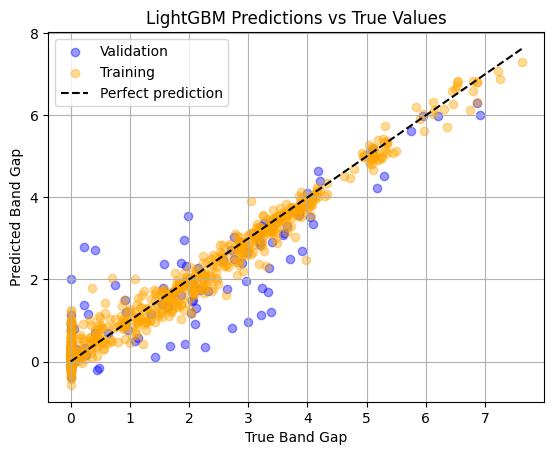

In [224]:
# Validation set
plt.scatter(y_val, y_val_pred, label='Validation', alpha=0.4, color='blue')

# Training set
plt.scatter(y_train, y_train_pred, label='Training', alpha=0.4, color='orange')

# 45-degree reference line
plt.plot([min(y_raw), max(y_raw)], [min(y_raw), max(y_raw)], '--k', label='Perfect prediction')

plt.xlabel("True Band Gap")
plt.ylabel("Predicted Band Gap")
plt.title("LightGBM Predictions vs True Values")
plt.legend()
plt.grid(True)
plt.show()

In [193]:
from sklearn.model_selection import RandomizedSearchCV

In [204]:
### GRID SEARCH
model = lgb.LGBMRegressor(objective='regression', random_state=42, n_jobs=-1, verbose = -1)
param_dist = {
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [3, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500, 1000],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}

# ----------------------------
# Randomized search
# ----------------------------
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,          # number of random combinations to try
    scoring='neg_root_mean_squared_error',
    cv=3,               # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# ----------------------------
# Best model and performance
# ----------------------------
best_model = random_search.best_estimator_
y_val_pred = best_model.predict(X_val)
rmse = mean_squared_error(y_val, y_val_pred)
print(f"Best params: {random_search.best_params_}")
print(f"Validation MSE: {rmse:.4f}")
# # ----------------------------
# # Grid search parameters
# # ----------------------------
# param_grid = {
#     'num_leaves': [7, 15, 31],         # tree complexity
#     'max_depth': [3, 4, 5],            # depth control
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [200, 500, 1000],  # number of boosting rounds
#     'reg_alpha': [0, 0.1, 0.5],
#     'reg_lambda': [1, 2, 5],
#     'subsample': [0.8, 1.0],           # row sampling
#     'colsample_bytree': [0.8, 1.0]     # feature sampling
# }

# # ----------------------------
# # GridSearchCV
# # ----------------------------
# grid = GridSearchCV(
#     estimator=lgb_model,
#     param_grid=param_grid,
#     scoring='neg_root_mean_squared_error',  # RMSE
#     cv=3,                                   # 3-fold cross-validation
#     verbose=1,
#     n_jobs=-1
# )

# grid.fit(X_train, y_train)

# # ----------------------------
# # Results
# # ----------------------------
# print("Best RMSE: ", -grid.best_score_)
# print("Best parameters: ", grid.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0

Best params: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'num_leaves': 127, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Validation MSE: 0.5711


In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 6,
    'n_estimators': 500,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'verbose': -1
}


In [ ]:
param_dist = {
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [3, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.5, 1],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}

# ----------------------------
# Randomized search
# ----------------------------
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,          # number of random combinations to try
    scoring='neg_root_mean_squared_error',
    cv=3,               # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

# ----------------------------
# Best model and performance
# ----------------------------
best_model = random_search.best_estimator_
y_val_pred = best_model.predict(X_val_scaled)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f"Best params: {random_search.best_params_}")
print(f"Validation RMSE: {rmse:.4f}")